In [2]:
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from scipy.stats import norm
import datetime as dt

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() # this has to be here in order for yahoo finance to work

# Forward and Futures Contract Pricing

In this part of the python code we are going to look at how futures and forward contracts are priced. We are going to graph these contracts against the spot market and see the different prices they obtain.

Forwards and futures contracts are a legal agreement to buy or sell certain asset at certain time. The main difference between the two is that futures contract is traded on the exchange like the CME, EUREX,...
but Futures contract is traded in the over the counter market between sofisticated market participants, therefore institutions.  
Forward contracts have a bigger credit risk and are ot as safe as the futures contracts which have practically no credit risk. The system of margin is set up to protect market participants against the default of the other side in their trades.

## Futures vs SPOT

Below is the comparision of futures market against the spot. In this case the futures derivative has as its underlying the S&P 500 contract, the biggest stock index in the wold and the most liquid futures contract. We can see that in the past the futures and spot differed a lot and now came together. This is because at hte start you could have shorted the contract and invested the credit at the risk free rate, therefore making extra money if the spot and futures would have had the same price.  
That is why we see that they have a different price, time value fo money is the key factor.

### E-mini S&P
We are simulating the E-mini S&P futures contract that is traded on the CME exchange in chicago, it is the biggest futures market and also the most well known. It is therefore perfect as an example. There are four maturities in a year being March June September and December(they are denoted as H, M, U, Z). therefore we can get the data for the ticker symbols being ESH24.CME ESM24.CME ESU24.CME ESZ24.CME. Numbers 24 represent the year 2024, if you are reading this and it is the next year you need to chenge this as it is going to cause exception due to yahoo finance deleting the data from the database.

[*********************100%***********************]  2 of 2 completed


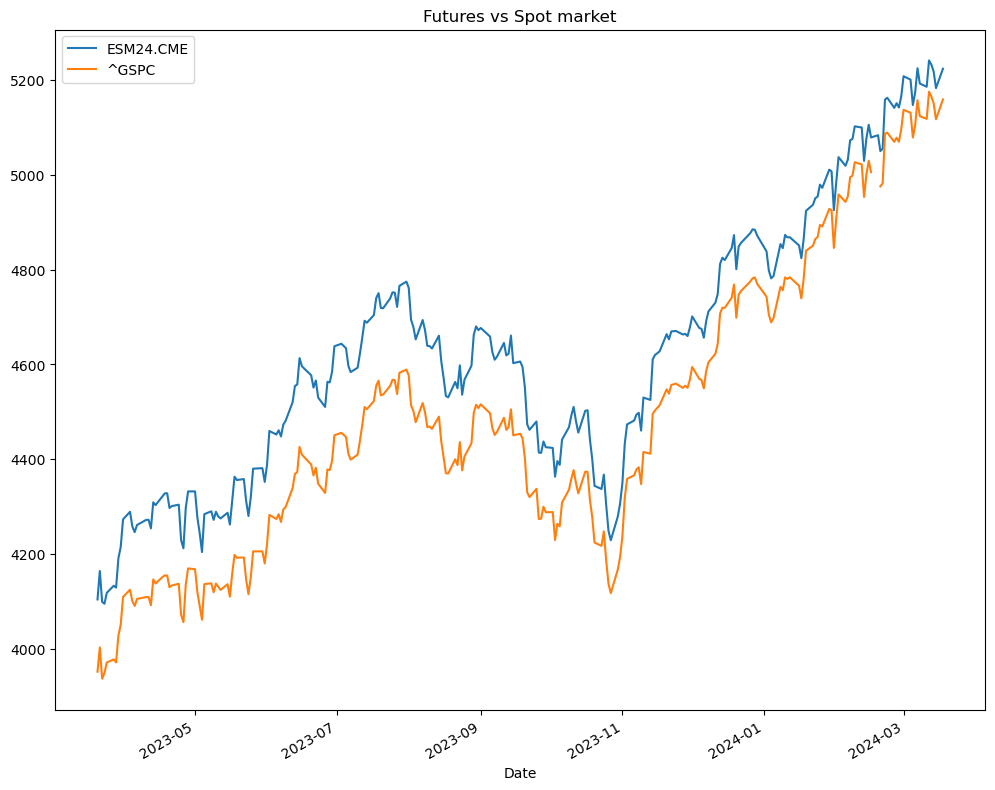

In [5]:
# We can see how the futures and spot prices do change
# In this image we can see the march s&p futures contract and spot price of s&p
# The difference bewtween the two is getting smaller as the maturity of the contract approaches
# Ticker symbols for E-mini S&P futures: ESH24.CME ESM24.CME ESU24.CME ESZ24.CME (replace the year if 2024 passed)

ticker_symbols = ['^GSPC', 'ESM24.CME']
end = dt.datetime.now()
start = end - dt.timedelta(days=365)

data = pdr.get_data_yahoo(ticker_symbols, start=start, end=end)['Adj Close']

data.plot(title="Futures vs Spot market", figsize=(12, 10))
plt.show()

## Calculating the price of the Futures contract

When we wanna claculate the futures price at the certain point time we have to know the underlying price,
divident being payed during the life of the contract, risk free rate and time to expiration fo the contract.
Then we can easily calculate the futures/forward contract price by calculating the future value of money, therefore multiplying the underlying price by the risk free rate and substracting the dividents being payed, because they are lowering the price of the contract.  
We can see that the formula is:

$
F = S_0 \times \left(1 + rT\right)
$

Variable Description:

- $F$: The futures price.
- $S_0$: The spot price of the underlying asset.
- $r$: The annual risk-free interest rate (expressed as a decimal).
- $T$: The time to maturity of the futures contract in years.

In [6]:
def forward_calculation(S: float, D: float, r: float, t: float)-> float:
    return S * (1 + r * t) - D # forward contract price

### Futures price model vs reality

Below is the graph very similar to the one above, showing ESH24 futures contract versus its spot underlying. I have simulated a 1 Year Futures contract to see why the price differs, how it is happening and that we understand the principles behind it. I have given my simulated contract bigger risk free rate that is available and therefore it is higher but that is just for the aesthetics, when risk free rate is lowered the simulation is very close to reality.

[*********************100%***********************]  2 of 2 completed


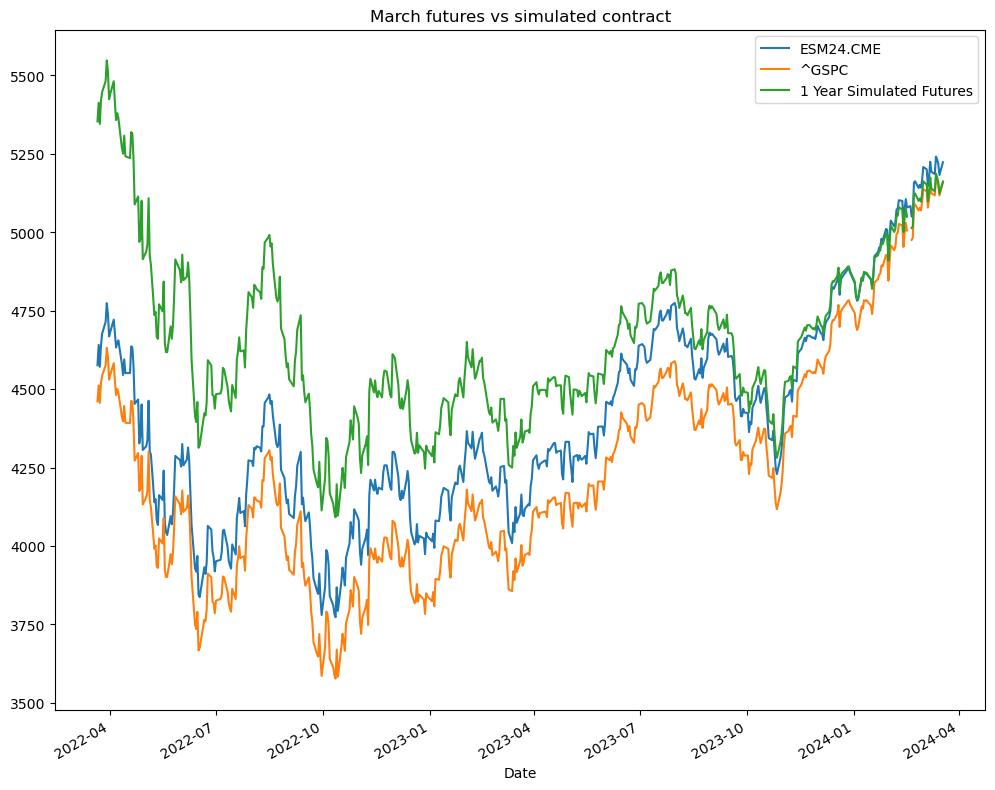

In [8]:
D = 0       
r = .1       
t = 2        

ticker_symbols = ['^GSPC', 'ESM24.CME']
end = dt.datetime.now()
start = end - dt.timedelta(days=365*t)
data = pdr.get_data_yahoo(ticker_symbols, start=start, end=end)['Adj Close']

maturity_as_date = data.index[0] + dt.timedelta(days=365*t)
time_list = (maturity_as_date - data.index).days / (365)

data['1 Year Simulated Futures'] = forward_calculation(data['^GSPC'], D, r, time_list) 

data.plot(title="March futures vs simulated contract", figsize=(12, 10))
plt.show()

# Binomial Asset Pricing model

Here I will add the description, math and logic behind the binomial option pricing model.

In [19]:
class BinomialTree:
    def __init__(self, r, t, S, K, sigma, N):
        self.r = r
        self.t = t
        self.S = S
        self.K = K
        self.sigma = sigma
        self.N = N
        
        self.board = []
        self.eur_opt_put = []
        self.eur_opt_call = []
        self.am_opt_call = []
        self.am_opt_put = []
        
        self.biggest_num = 5
        self.empty_line = " "
        
        self.call_price = 0
        self.put_price = 0
        self.am_call_price = 0
        self.am_put_price = 0
        
        self.calc()
            
    def __str__():
        return "< r={} t={} S={} K={} sigma={} N={} >".format(self.r, self.t, self.S, self.K, self.sigma, self.N)
    
    def calc(self):
        
        r = self.r              
        t = self.t              
        S = self.S
        K = self.K
        rows = self.N           
        sigma = self.sigma      

        dt = t/(rows - 1)
        u = math.e**(sigma*math.sqrt(dt))
        d = 1/u          
        cols = 2*(rows - 1) + 4
        p = (math.e ** (r * dt) - d) / (u - d)

        board = self.board
        biggest_num = 1
        
        put_price = 0
        call_price = 0
        am_call_price = 0
        am_put_price = 0

        for row in range(rows):
            board.append([])
            for col in range(cols):
                board[row].append([])

                if col == cols/2 and row == 0:
                    board[row][col] = S
                elif row != 0 and col != 0 and col != cols-1 and ( board[row-1][col-1] != self.empty_line 
                                                                  or board[row-1][col+1] != self.empty_line ):
                    if board[row-1][col-1] != self.empty_line:
                        board[row][col] = str(float(board[row-1][col-1]) * d)
                    else:
                        board[row][col] = str(float(board[row-1][col + 1]) * u)            
                else:
                    board[row][col] = self.empty_line        

        for row in range(rows):
            for col in range(cols):
                if board[row][col] != self.empty_line and len(str(round(float(board[row][col]), 2))) > biggest_num:
                    biggest_num = len(str(round(float(board[row][col]), 2)))
        self.biggest_num = biggest_num

        eur_opt_put = copy.deepcopy(board)
        self.eur_opt_put = eur_opt_put
        eur_opt_call = copy.deepcopy(board)
        self.eur_opt_call = eur_opt_call
        am_opt_call = copy.deepcopy(board)
        self.am_opt_call = am_opt_call
        am_opt_put = copy.deepcopy(board)
        self.am_opt_put = am_opt_put

        # European Put Option
        for row in range(rows - 1, -1, -1):
            for col in range(cols):
                if eur_opt_put[row][col] == self.empty_line:
                    continue
                elif row == (rows - 1):
                    eur_opt_put[row][col] = max(K - float(eur_opt_put[row][col]), 0)
                else:
                    eur_opt_put[row][col] = math.e**((-r)*dt) * (p * (eur_opt_put[row + 1][col - 1]) 
                                                                 + (1-p) * (eur_opt_put[row + 1][col + 1]))
                    if row == 0:
                        put_price = eur_opt_put[row][col]

        # European Call Option
        for row in range(rows - 1, -1, -1):
            for col in range(cols):
                if eur_opt_call[row][col] == self.empty_line:
                    continue
                elif row == (rows - 1):
                    eur_opt_call[row][col] = max(float(eur_opt_call[row][col]) - K, 0)
                else:
                    eur_opt_call[row][col] = math.e**((-r)*dt) * (p * (eur_opt_call[row + 1][col - 1]) 
                                                                  + (1-p) * (eur_opt_call[row + 1][col + 1]))
                    if row == 0:
                        call_price = eur_opt_call[row][col]
                        
        # American Call Option
        for row in range(rows - 1, -1, -1):
            for col in range(cols):
                if am_opt_call[row][col] == self.empty_line:
                    continue
                elif row == (rows - 1):
                    am_opt_call[row][col] = max(float(am_opt_call[row][col]) - K, 0)
                else:
                    am_opt_call[row][col] = math.e**((-r)*dt) * (p * (am_opt_call[row + 1][col - 1]) 
                                                                 + (1-p) * (am_opt_call[row + 1][col + 1]))
                    if float(am_opt_call[row][col]) < float(board[row][col]) - K:
                        am_opt_call[row][col] = float(board[row][col]) - K
                    if row == 0:
                        am_call_price = am_opt_call[row][col]
                        
        # American Put option
        for row in range(rows - 1, -1, -1):
            for col in range(cols):
                if am_opt_put[row][col] == self.empty_line:
                    continue
                elif row == (rows - 1):
                    am_opt_put[row][col] = max(K - float(am_opt_put[row][col]), 0)
                else:
                    am_opt_put[row][col] = math.e**((-r)*dt) * (p * (am_opt_put[row + 1][col - 1]) 
                                                                + (1-p) * (am_opt_put[row + 1][col + 1]))
                    if float(am_opt_put[row][col]) < K - float(board[row][col]):
                        am_opt_put[row][col] = K - float(board[row][col])
                    if row == 0:
                        am_put_price = am_opt_put[row][col]
        
        self.call_price = call_price
        self.put_price = put_price
        self.am_call_price = am_call_price
        self.am_put_price = am_put_price        

# Black-Scholes Merton Model

Below are the equations for Call and Put options contract:  

$
C(S_{t},K,t)=S_{t}\Phi (d_{1})-Ke^{-r(T-t)}\Phi (d_{2})
$  

$
P(S_{t},K,t)=Ke^{-r(T-t)}\Phi (-d_{2})-S_{t}\Phi (-d_{1})
$  

$
d_{1}=\frac{\ln\frac{S_{t}}{K} + (r + \frac{\sigma^2}{2})\tau}{\sigma\sqrt{\tau}}
$  

$
d_{2}=d_{1}-\sigma\sqrt{\tau}
$

Below is the Black Scholes Merton Partial Differential Equation.

$
\begin{equation}
	\frac{\partial \mathrm C}{ \partial \mathrm t } + \frac{1}{2}\sigma^{2} \mathrm S^{2} \frac{\partial^{2} \mathrm C}{\partial \mathrm C^2}
	+ \mathrm r \mathrm S \frac{\partial \mathrm C}{\partial \mathrm S}\ =
	\mathrm r \mathrm C 
	\label{eq:1}
\end{equation}
$

In [27]:
class BlackScholes:
    def __init__(self, r, S, K, T, sigma):
        self.r = r
        self.S = S
        self.K = K
        self.T = T
        self.sigma = sigma
        
        self.asset_prices_calc()
    
    def asset_prices_calc(self):
        "Calculate BS price of call/put"
        r = self.r
        S = self.S
        K = self.K
        T = self.T
        sigma = self.sigma
        
        call_price = 0
        put_price = 0
        
        d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)

        
        call_price = price = S*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        put_price = price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S*norm.cdf(-d1, 0, 1)

        return call_price, put_price
    
    def delta_calc(self):
        "Calculate delta of an option"
        d1 = (np.log(self.S/self.K) + (self.r + self.sigma**2/2)*self.T)/(self.sigma*np.sqrt(self.T))
        
        delta_call_calc = 0
        delta_put_calc = 0
        
        delta_call_calc = norm.cdf(d1, 0, 1)
        delta_put_calc = -norm.cdf(-d1, 0, 1)
        
        return delta_call_calc, delta_put_calc
    
    def gamma_calc(self):
        "Calculate gamma of a option"
        d1 = (np.log(self.S/self.K) + (self.r + self.sigma**2/2)*self.T)/(self.sigma*np.sqrt(self.T))
        d2 = d1 - self.sigma*np.sqrt(self.T)
        
        gamma_calc = norm.pdf(d1, 0, 1)/(self.S*self.sigma*np.sqrt(self.T))
        
        return gamma_calc
    
    def vega_calc(self):
        "Calculate BS price of call/put"
        d1 = (np.log(self.S/self.K) + (self.r + self.sigma**2/2)*self.T)/(self.sigma*np.sqrt(self.T))
        d2 = d1 - self.sigma*np.sqrt(self.T)
        
        vega_calc = S*norm.pdf(d1, 0, 1)*np.sqrt(self.T)
        
        return vega_calc*0.01
    
    def theta_calc(self):
        "Calculate BS price of call/put"
        d1 = (np.log(self.S/self.K) + (self.r + self.sigma**2/2)*self.T)/(self.sigma*np.sqrt(self.T))
        d2 = d1 - self.sigma*np.sqrt(self.T)

        theta_call_calc = 0
        theta_put_calc = 0

        theta_call_calc = -self.S*norm.pdf(d1, 0, 1)*self.sigma/(2*np.sqrt(self.T)) - self.r*self.K*np.exp(-self.r*self.T)*norm.cdf(d2, 0, 1)
        theta_put_calc = -self.S*norm.pdf(d1, 0, 1)*self.sigma/(2*np.sqrt(self.T)) + self.r*self.K*np.exp(-self.r*self.T)*norm.cdf(-d2, 0, 1)

        return theta_call_calc/365, theta_put_calc/365
    
    def rho_calc(self):
        "Calculate BS price of call/put"
        d1 = (np.log(self.S/self.K) + (self.r + self.sigma**2/2)*self.T)/(self.sigma*np.sqrt(self.T))
        d2 = d1 - self.sigma*np.sqrt(self.T)
        
        rho_call_calc = 0
        rho_put_calc = 0
        
        rho_call_calc = K*T*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        rho_put_calc = -K*T*np.exp(-r*T)*norm.cdf(-d2, 0, 1)
        
        return rho_call_calc*0.01, rho_put_calc*0.01

## Difference between Binomial and Black Scholes Model

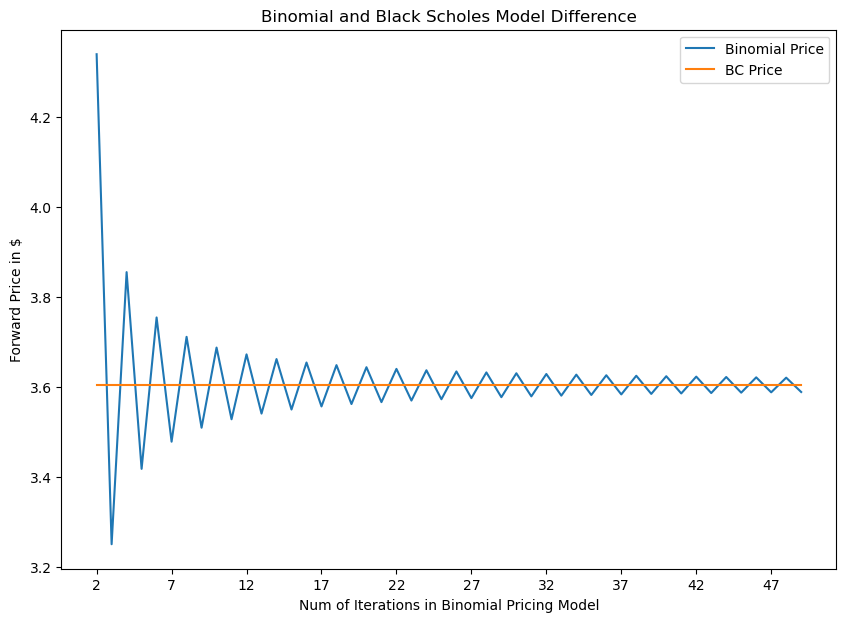

In [7]:
r = .05                # risk free rate
S = 20                 # initial stock price
K = 20                 # strike price
T = 1                  # time in years
iterations = 50        # number of iterations
sigma = 0.4            # volatility
binom_prices = []      # list of prices calculated by the binomial pricing model
binom_iterations = []  # iterations x-axys

for N in range(2, iterations):
    binom_prices.append(BinomialTree(r, T, S, K, sigma, N).call_price)
    binom_iterations.append(N)

BS = BlackScholes(r, S, K, T, sigma)    

plt.subplots(figsize=(10, 7))
plt.plot(binom_iterations, binom_prices)
plt.plot(binom_iterations, [BS.asset_prices_calc()[0]] * len(binom_prices))
plt.xticks(np.arange(2, iterations, step=int(iterations/10)))
plt.legend(['Binomial Price', 'BC Price'])
plt.xlabel("Num of Iterations in Binomial Pricing Model")
plt.ylabel("Forward Price in $")
plt.title("Binomial and Black Scholes Model Difference")
plt.show()

## Black Scholes visualisation

In [8]:
r = .05               # risk free rate
K = 100               # strike price
sigma = 0.3           # volatility

X = np.arange(K-40, K+40)
y_end = 2
y_start = .05
Y = np.arange(y_start, y_end, (y_end- y_start)/len(X))

X, Y = np.meshgrid(X, Y)
stack = np.dstack([X, Y])
Z_call = np.zeros((len(Y), len(X)))
Z_put = np.zeros((len(Y), len(X)))

delta_c = np.zeros((len(Y), len(X)))
delta_p = np.zeros((len(Y), len(X)))
gamma = np.zeros((len(Y), len(X)))
vega = np.zeros((len(Y), len(X)))
theta_c = np.zeros((len(Y), len(X)))
theta_p = np.zeros((len(Y), len(X)))
rho_c = np.zeros((len(Y), len(X)))
rho_p = np.zeros((len(Y), len(X)))

for S in range(len(X)):
    for T in range(len(Y)):
        spot = stack[S][T][0]
        time = stack[S][T][1]
        BS = BlackScholes(r, spot, K, time, sigma)
        # 0 -> Call, 1 -> Put
        Z_call[S][T] = BS.asset_prices_calc()[0] 
        Z_put[S][T] = BS.asset_prices_calc()[1]
        
        delta_c[S][T] = BS.delta_calc()[0]
        delta_p[S][T] = BS.delta_calc()[1]
        gamma[S][T] = BS.gamma_calc()
        vega[S][T] = BS.vega_calc()
        theta_c[S][T] = BS.theta_calc()[0]
        theta_p[S][T] = BS.theta_calc()[1]
        rho_c[S][T] = BS.rho_calc()[0]
        rho_p[S][T] = BS.rho_calc()[1]

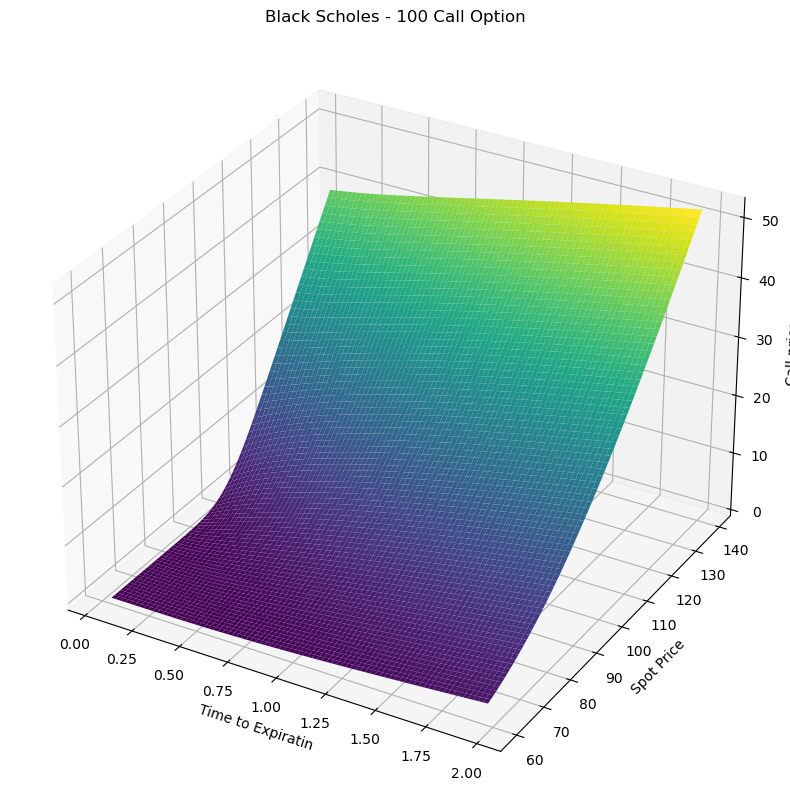

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10)) 

# Plot the surface.
surf = ax.plot_surface(Y, X, Z_call, rstride=1, cstride=1, cmap=cm.viridis, shade='interp')

ax.set_title('Black Scholes - {} Call Option'.format(K))
ax.set_xlabel('Time to Expiratin')
ax.set_ylabel('Spot Price')
ax.set_zlabel('Call price')

plt.show()

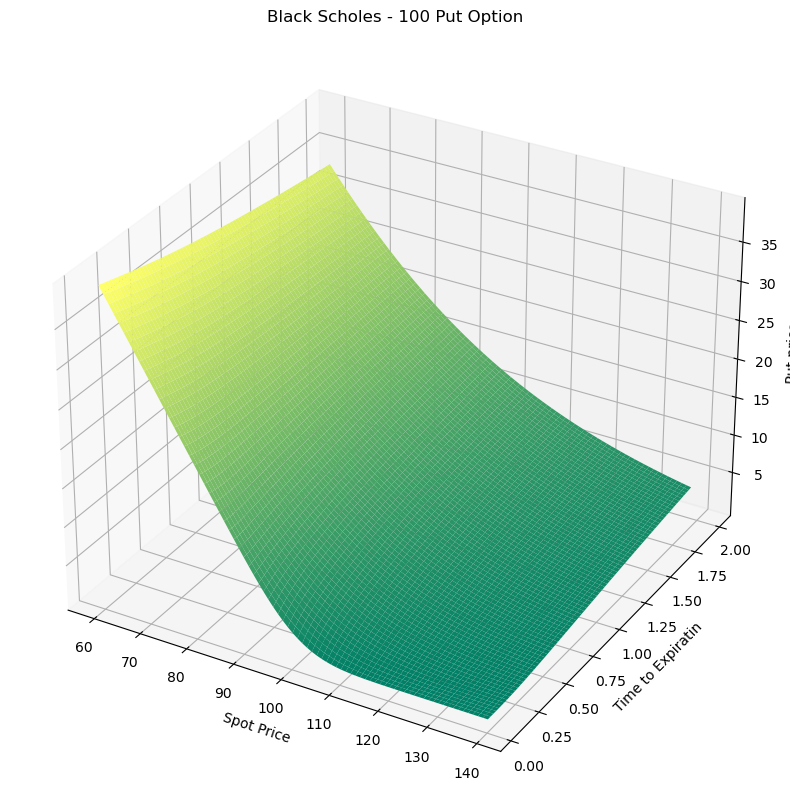

In [10]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10)) 

surf = ax.plot_surface(X, Y, Z_put, rstride=1, cstride=1, cmap=cm.summer, shade='interp')

ax.set_title('Black Scholes - {} Put Option'.format(K))
ax.set_xlabel('Spot Price')
ax.set_ylabel('Time to Expiratin')
ax.set_zlabel('Put price')

plt.show()

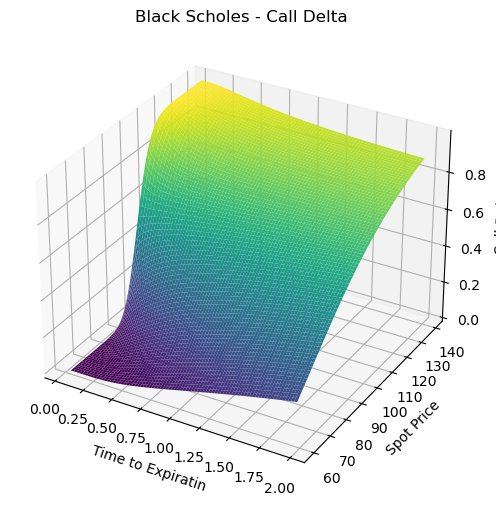

In [11]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(6, 6)) 

# Plot the surface.
surf = ax.plot_surface(Y, X, delta_c, rstride=1, cstride=1, cmap=cm.viridis, shade='interp')

ax.set_title('Black Scholes - Call Delta')
ax.set_xlabel('Time to Expiratin')
ax.set_ylabel('Spot Price')
ax.set_zlabel('Call Delta')

plt.show()

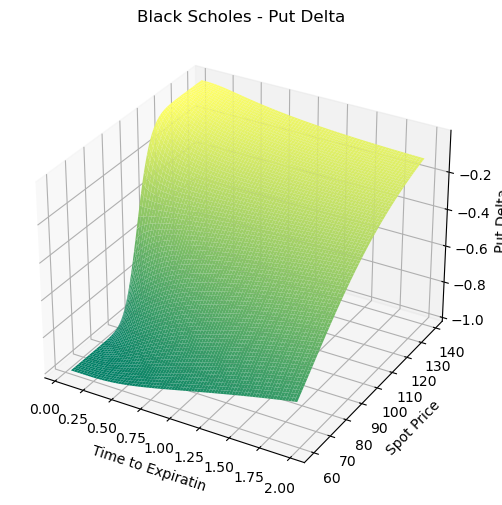

In [12]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(6, 6)) 

# Plot the surface.
surf = ax.plot_surface(Y, X, delta_p, rstride=1, cstride=1, cmap=cm.summer, shade='interp')

ax.set_title('Black Scholes - Put Delta')
ax.set_xlabel('Time to Expiratin')
ax.set_ylabel('Spot Price')
ax.set_zlabel('Put Delta')

plt.show()

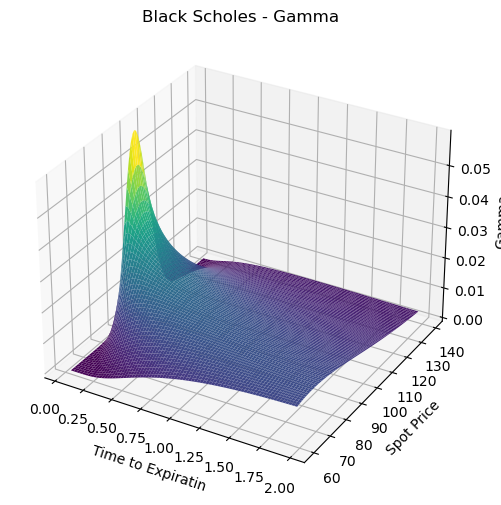

In [13]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(6, 6)) 

# Plot the surface.
surf = ax.plot_surface(Y, X, gamma, rstride=1, cstride=1, cmap=cm.viridis, shade='interp')

ax.set_title('Black Scholes - Gamma')
ax.set_xlabel('Time to Expiratin')
ax.set_ylabel('Spot Price')
ax.set_zlabel('Gamma')

plt.show()

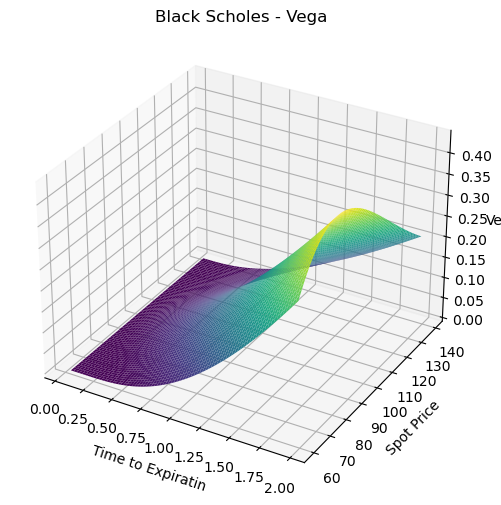

In [14]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(6, 6)) 

# Plot the surface.
surf = ax.plot_surface(Y, X, vega, rstride=1, cstride=1, cmap=cm.viridis, shade='interp')

ax.set_title('Black Scholes - Vega')
ax.set_xlabel('Time to Expiratin')
ax.set_ylabel('Spot Price')
ax.set_zlabel('Vega')

plt.show()

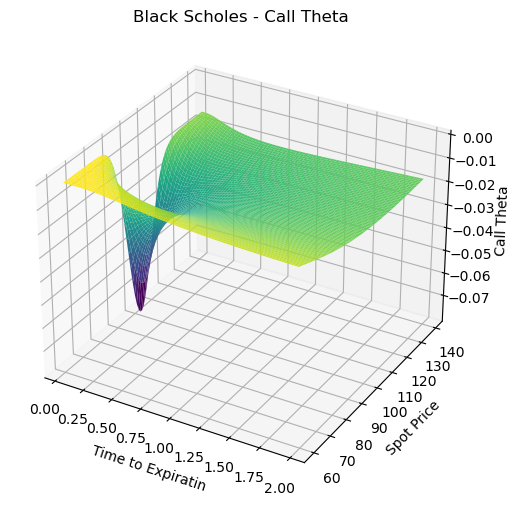

In [15]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(6, 6)) 

# Plot the surface.
surf = ax.plot_surface(Y, X, theta_c, rstride=1, cstride=1, cmap=cm.viridis, shade='interp')

ax.set_title('Black Scholes - Call Theta')
ax.set_xlabel('Time to Expiratin')
ax.set_ylabel('Spot Price')
ax.set_zlabel('Call Theta')

plt.show()

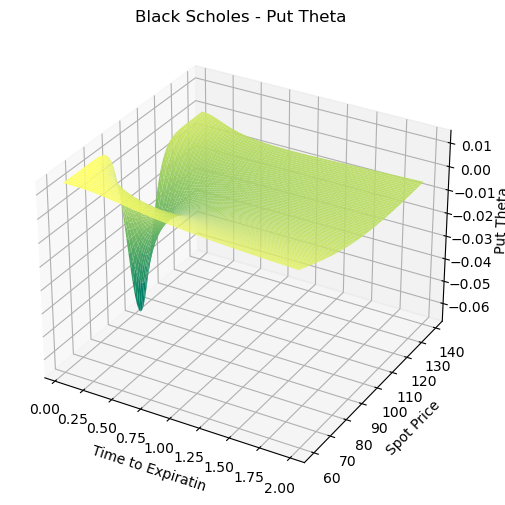

In [16]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(6, 6)) 

# Plot the surface.
surf = ax.plot_surface(Y, X, theta_p, rstride=1, cstride=1, cmap=cm.summer, shade='interp')

ax.set_title('Black Scholes - Put Theta')
ax.set_xlabel('Time to Expiratin')
ax.set_ylabel('Spot Price')
ax.set_zlabel('Put Theta')

plt.show()

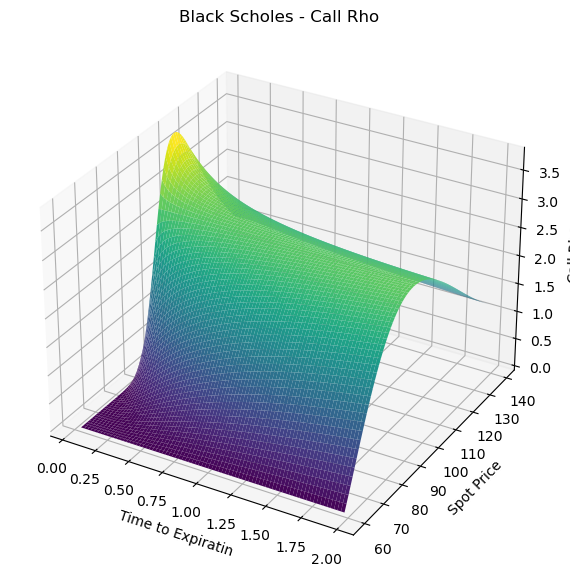

In [17]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(7, 7)) 

# Plot the surface.
surf = ax.plot_surface(Y, X, rho_c, rstride=1, cstride=1, cmap=cm.viridis, shade='interp')

ax.set_title('Black Scholes - Call Rho')
ax.set_xlabel('Time to Expiratin')
ax.set_ylabel('Spot Price')
ax.set_zlabel('Call Rho')

plt.show()

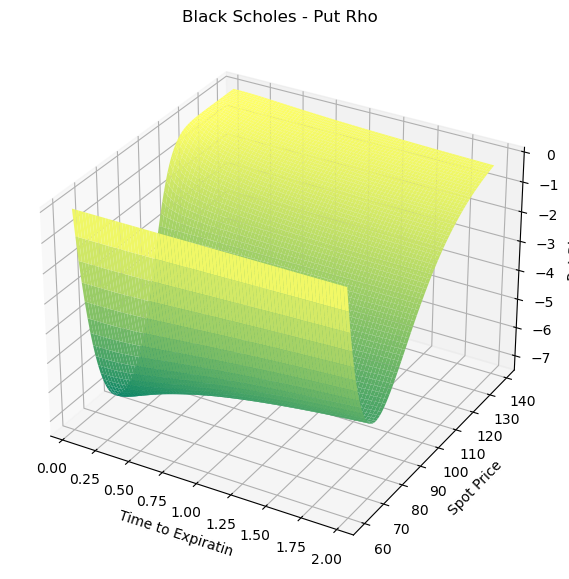

In [18]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(7, 7)) 

# Plot the surface.
surf = ax.plot_surface(Y, X, rho_p, rstride=1, cstride=1, cmap=cm.summer, shade='interp')

ax.set_title('Black Scholes - Put Rho')
ax.set_xlabel('Time to Expiratin')
ax.set_ylabel('Spot Price')
ax.set_zlabel('Put Rho')

plt.show()